In [127]:
import os
import pandas as pd
import pathlib
import numpy as np
import torch
import matplotlib.pyplot as plt
import time


from tqdm import tqdm
from sklearn.model_selection import train_test_split
from ast import literal_eval
from torch import nn
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

%load_ext tensorboard
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Using device: cuda


In [128]:
# f'cartpole-{time.strftime("%Y%m%d-%H%M%S")}'

In [129]:
writer = SummaryWriter(f'runs/cartpole-{time.strftime("%Y%m%d-%H%M%S")}')
%tensorboard --logdir=runs

Reusing TensorBoard on port 6006 (pid 1515880), started 1:07:06 ago. (Use '!kill 1515880' to kill it.)

## Define Dataset and DataLoader

In [130]:
class CartpoleNLPDataset(Dataset):
    def __init__(self, nlp_results_path, train):
        self.df = pd.read_csv(path)

        # Process columns of the dataframe that contain arrays that are formatted as strings in the csv
        array_elements = ['params', 'X', 'U']
        for elem in array_elements:
            self.df[elem] = self.df[elem].apply(literal_eval) # Convert strings into lists 
            self.df[elem] = self.df[elem].apply(lambda x: np.array(x, dtype=np.float64)) # Convert lists into np arrays of type np.float64

        # Split the data into training and testing sets
        train_df, test_df = train_test_split(self.df, test_size=0.2)

        if train:
            self.df = train_df
        else:
            self.df = test_df

        # Store the number of params (NN inputs) and length of trajectory (NN outputs)
        self.n_params = len(self.df['params'].iloc[0])
        N = self.df['X'].iloc[0].shape[0] # number of timesteps
        n_states = len(self.df['X'].iloc[0][0])
        n_controls = len(self.df['U'].iloc[0][0])

        # print(n_states)
        # print(n_controls)
        # print(N)
        self.n_traj = n_states*N + n_controls*(N-1)

    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        params = self.df.iloc[idx].params
        X = self.df.iloc[idx].X
        U = self.df.iloc[idx].U
        
        Z = np.array([np.hstack((X[i], U[i])) for i in range(len(U))], dtype=np.float64) # create the trajectory vector where element z_i = [x_i, u_i]
        Z = Z.flatten()
        # print(Z[-6:])
        # print(Z.shape)
        Z = np.concatenate((Z, X[-1])) # add the final state to the end of the trajectory
        # print(Z[-6:])
        # print(Z.shape)
        # print()

        return params, Z
    def getitem(self, idx):
        params = self.df.iloc[idx].params
        X = self.df.iloc[idx].X
        U = self.df.iloc[idx].U
        
        Z = np.array([np.hstack((X[i], U[i])) for i in range(len(U))]) # create the trajectory vector where element z_i = [x_i, u_i]
        
        return params, Z

    

In [131]:
path = 'data/cartpole_DIRCOL_5000.csv'
train_data = CartpoleNLPDataset(path, train=True)
test_data = CartpoleNLPDataset(path, train=False)
# print(train_data.getitem(0)[1].dtype)
print(train_data.n_traj)

train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=True)

params, Z = next(iter(train_dataloader))
# print(params.shape)
# print(Z.shape)


204


In [132]:
cartpole_data = CartpoleNLPDataset(path, train=True)
cartpole_data.n_params
cartpole_data.n_traj
# cartpole_data.df['X'].iloc[0].shape[0]

204

## Define the NN

In [133]:
class CartpoleNN(nn.Module):
    def __init__(self, n_params, n_traj):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_params, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_traj)
        )
        self.linear_relu_stack = self.linear_relu_stack.double()

        
    def forward(self, params):
        # params = self.flatten(params)
        traj = self.linear_relu_stack(params)
        return traj


In [134]:
model = CartpoleNN(cartpole_data.n_params, cartpole_data.n_traj).to(device)
print(f"Model structure: {model}\n\n")

# for name, param in model.named_parameters():
#     print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")


Model structure: CartpoleNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=204, bias=True)
  )
)




## Training Loop

In [135]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()

    for batch, (X,y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)



        pred = model(X)
        loss = loss_fn(pred, y)

        # Backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 50 == 0:
            writer.add_scalar('train loss x batch', loss, batch)
            loss, current = loss.item(), batch * len(X)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            


def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches # average loss per batch
    # print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")


    return test_loss




In [136]:
learning_rate = 5e-3
batch_size = 64
epochs = 100

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

for t in tqdm(range(epochs)):
    # print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    scheduler.step()

    test_loss = test_loop(test_dataloader, model, loss_fn)
    writer.add_scalar('test loss x epoch', test_loss, t)



writer.flush()
writer.close()
print("Done!")


100%|██████████| 100/100 [01:38<00:00,  1.02it/s]

Done!


## Visualize and Track Trajectory

In [142]:
# model = torch.load('models/cartpole_model1.pth')
model.eval()
# rand_param = torch.rand()

param_lower = [0.0, 0.0]
param_upper = [0.2, np.pi/2]

rand_param = torch.rand(len(param_lower)) * (torch.tensor(param_upper) - torch.tensor(param_lower)) + torch.tensor(param_lower)
rand_param = rand_param.double()

Z = None
with torch.no_grad():
    rand_param = rand_param.to(device)
    start = time.process_time()
    Z = model(rand_param)
    end = time.process_time()
Z = Z.detach().cpu().numpy()

print(end-start)


0.00028923200000008364


(204,)
(41, 4)


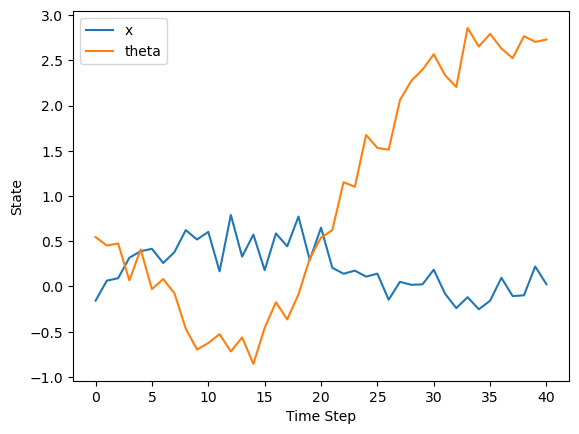

In [138]:
from utils.trajectory_utils import create_idx
nx, nu, N = 4, 1, 41
# nx, nu, N, nz, nc, x, u, c= create_idx(nx, nu, N)
idx = create_idx(nx, nu, N)
idx.x

print(Z.shape)
print(Z[idx.x].shape)
plt.plot(Z[idx.x][:,:2])

plt.xlabel('Time Step')
plt.ylabel('State')
plt.legend(['x', 'theta'])

In [139]:
params, traj = cartpole_data.getitem(0)

traj.shape

(40, 5)